## Clip Image Collection 
The following script checks if the geehydro package has been installed. If not, it will install geehydro, which automatically install its dependencies, including earthengine-api and folium.

In [1]:
import subprocess

try:
    import geehydro
except ImportError:
    print('geehydro package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geehydro'])

Import libraries

In [2]:
import ee
import folium
import geehydro
import numpy as np
import geemap
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import time
from PIL import Image
import cv2
from google.cloud import storage

2023-01-11 16:42:24.540650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 16:42:24.753334: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-11 16:42:24.753355: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-11 16:42:25.875467: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Authenticate and initialize Earth Engine API. You only need to authenticate the Earth Engine API once. 

In [3]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()


# Parameters

In [231]:
# TIME RANGE AND BIG AREAS

# time range to get the picture
# [period_start, period_end]
time_periods = [['2022-04-25', '2022-04-29']]

# list with all the big areas to consider
# [right_top_longitude, right_top_latitude, left_bottom_longitude , left_bottom_latitude]
areas_list = [[ -78.7822,  -2.8989, -77.0138,  -7.1010],  # Amazonas province
              [ -76.0802,  -7.2645, -70.3908, -11.4990]]  # Ucayali province
areas_list = [[ -78.7822,  -2.8989, -77.0138,  -7.1010]]  # Amazonas province


# r_lat_left =-9.8058
# r_lon_left = -74.0015
# r_lat_right = -9.9464
# r_lon_right =  -73.8160

# incr = 0.001

# r_lat_left = -2.8989-incr
# r_lon_left = -78.7822+incr
# # r_lat_right = -3.1008-incr
# # r_lon_right = -78.1899+incr

# r_lat_right = -3.0638
# r_lon_right = -78.5359


# areas_list = [[ r_lon_left,  r_lat_left, r_lon_right,  r_lat_right]]  # Amazonas province


# IMAGE PARAMETERS

# size of chip side 
chip_size = 256

# satellite scale (m)
scale = 10

# size of chip (m) 
dist =  chip_size*scale/1000*(3/5)

# overlap in chip sampling of big images
overlap = 0.33

# relevant bands
bands = ['B4','B3','B2']

# min and max pixel values
min_px = 0
max_px = 3000

# layer properties dictionary
rgbVis = {
    'bands': bands, 
    'min': min_px , 
    'max' : max_px}


# GOOGLE CLOUD PARAMETERS

# bucket name
bucket_name = 'peru_images'



# Functions

## Cloud functions
- create folder


In [232]:
# Initialize cloud storage
def init_cloud_storage(bucket_name):
    
    """
    Create a storage client for google cloud
    Inputs: - name of bucket
    Outputs: - bucket
            - storage client
    """   
    
    
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)

    return bucket, storage_client


In [233]:
def create_bucket_folder(time_period, bucket, storage_client):
    
    """
    Create a folder for each time period in the bucket and return the corresponding blob
    Inputs: - time period of the folder
            - bucket name
            - storage client
    Outputs: - folder blob
    """
    
    folder_name = f'{time_period[0]}_{time_period[1]}'
    
    if  storage.Blob(bucket=bucket, name=f'{folder_name}/').exists(storage_client) == True:
        blob = bucket.blob(f'{folder_name}/')
        blob.delete()
        
    blob = storage.Blob(f'{folder_name}/', bucket)
    blob.upload_from_string('')    
    
    return blob

## Earth Engine functions
- download big area images (pre chipping)

In [234]:
def download_big_area(time_period, area, bands):
    
    """
    Download the big area pictures (the size of a peruvian province usually)
    Inputs: - time period of the download
            - area to download
            - satellite bands
            
    Outputs: - image
    """
    
    countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017");
    country_selection = countries.filter(ee.Filter.Or(ee.Filter.eq("country_na","Peru"),
                                                      ee.Filter.eq("country_na","Brazil"),
                                                      ee.Filter.eq("country_na","Ecuador")))


    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(time_period[0], time_period[1]) \
          .filterBounds(country_selection)
    image1 = collection.median()

    image2 = image1.clipToCollection(country_selection)

    # Select the red, green and blue bands.
    image = image2.select(bands)
    
    r_rec = ee.Geometry.Rectangle(area)    
    clipped = image.clip(r_rec)
    
    return clipped

In [235]:
def save_image_in_bucket_folder(image, area, scale, bucket, blob):
    
    print(bucket.name)
    print(blob.name)
    
    start = time.time()
    
    start_lon = area[0]
    start_lat = area[1]
    end_lon = area[2]
    end_lat = area[3]
    
    geometry = [[start_lon,start_lat], [start_lon,end_lat], [end_lon,end_lat], [end_lon,start_lat]]

    # Export the image, specifying scale and region.
    task = ee.batch.Export.image.toCloudStorage(**{
        'image': image,
        'description': f"lon_{start_lon:.5f}_lat_{start_lat:.5f}_lon_{end_lon:.5f}_lat_{end_lat:.5f}",
        'scale': scale,
        'region': geometry,
        'fileFormat': 'GeoTIFF',
        'bucket': bucket.name,
        'formatOptions': {'cloudOptimized': True},
        'fileNamePrefix': f'{blob.name}lon_{area[0]:.5f}_lat_{area[1]:.5f}_lon_{end_lon:.5f}_lat_{end_lat:.5f}'
    })
    task.start()
    
    print(f'upload time (s) : {time.time() - start:.5f}' )

## Cartography functions
- distance to coordinates
- distance to latitude
- distance to longitude
- coordinates to distance

In [236]:
def dist_2_coord(lon,lat,dist):
    
    """
    Calculates the longitude and latitude of a point on the opposide corner of a square (same distance for longitude and latitude)
    Inputs: - initial longitude (top left)
            - initial latitude (top left)
            - distance
            
    Outputs:- final longitude (bottom right)
            - final latitude (bottom right)
    """
    
    # Haversine formula: dist/(2*R) = 
#             np.arcsin(np.sqrt(np.sin((r_lat_right-r_lat_left)/2)**2 + 
#             np.cos(r_lat_left)*np.cos(r_lat_right)*np.sin((r_lon_right-r_lon_left)/2)**2))

    
    R = 6378.137 # Earth radius in km  
#     lat1 = lat - 2*np.arcsin(np.sqrt(np.sin(dist/(2*R))**2))
#     lon1 = lon + 2*np.arcsin(np.sqrt((np.sin(dist/(2*R)))**2/(np.cos(lat))**2))  
    lat1 = lat - 2*R*np.arcsin(np.sqrt(np.sin(np.deg2rad(dist/(2*R)))**2))
    lon1 = lon + 2*R*np.arcsin(np.sqrt(np.sin(np.deg2rad(dist/(2*R)))**2/(np.cos(np.deg2rad(lat))**2)))

    return lon1, lat1

In [237]:
def dist_2_coord_lat(lat,dist):
    
    """
    Calculates the latitude of a point at a certain distance 
    Inputs: - initial latitude (top left)
            - distance in km
            
    Outputs:- final latitude (bottom right)
    """
    
    
    # Haversine formula: dist/(2*R) = 
#             np.arcsin(np.sqrt(np.sin((r_lat_right-r_lat_left)/2)**2 + 
#             np.cos(r_lat_left)*np.cos(r_lat_right)*np.sin((r_lon_right-r_lon_left)/2)**2))
    
    R = 6378.137 # Earth radius in km  
#     return lat - 2*np.arcsin(np.sqrt(np.sin(dist/(2*R))**2))
    return lat - 2*R*np.arcsin(np.sqrt(np.sin(np.deg2rad(dist/(2*R)))**2))


In [238]:
def dist_2_coord_lon(lon,lat,dist):
    
    """
    Calculates the longitude and latitude of a point at a certain distance (same distance for longitude and latitude)
    Inputs: - initial longitude (top left)
            - initial latitude (top left)
            - distance in km
            
    Outputs:- final longitude (bottom right)
    """
    
    
    # Haversine formula: dist/(2*R) = 
#             np.arcsin(np.sqrt(np.sin((r_lat_right-r_lat_left)/2)**2 + 
#             np.cos(r_lat_left)*np.cos(r_lat_right)*np.sin((r_lon_right-r_lon_left)/2)**2))

    R = 6378.137 # Earth radius in km  
#     return lon + 2*np.arcsin(np.sqrt((np.sin(dist/(2*R)))**2/(np.cos(lat))**2))
    return lon + 2*R*np.arcsin(np.sqrt((np.sin(np.deg2rad(dist/(2*R)))**2/(np.cos(np.deg2rad(lat)))**2)))
                               
                               
            

In [239]:
def coord_2_dist(lon1,lat1,lon2,lat2):
    
    """
    Calculates the distance between 2 points defined by longitude and latitude
    Inputs: - initial longitude (top left)
            - initial latitude (top left)
            - final longitude (bottom right)
            - final latitude (bottom right)
            
    Outputs:- distance in km
    """
    
    # Haversine formula: dist/(2*R) = 
#             np.arcsin(np.sqrt(np.sin((r_lat_right-r_lat_left)/2)**2 + 
#             np.cos(r_lat_left)*np.cos(r_lat_right)*np.sin((r_lon_right-r_lon_left)/2)**2))

    R = 6378.137 # Earth radius in km  
  
#     dist = 2*R*np.arcsin(np.sqrt(np.sin((lat2-lat1)/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin((lon2-lon1)/2)**2))
    dist = 2*R*np.arcsin(np.sqrt(np.sin(np.deg2rad((lat2-lat1)/2))**2 + 
                                 np.cos(np.deg2rad(lat1))*np.cos(np.deg2rad(lat2))*np.sin(np.deg2rad((lon2-lon1)/2))**2))

    return dist

In [250]:
def chipping_grid(outer_area, dist, overlap, margin):
    
    """
    Creates the grid for the chips
    Inputs: - initial longitude (top left)
            - initial latitude (top left)
            - distance
            - margin 
            
    Outputs:- final longitude (bottom right)
            - final latitude (bottom right)
    """
    
    margin = 0.005
    
    start_lon = outer_area[0]
    start_lat = outer_area[1]
    end_lon = outer_area[2]
    end_lat = outer_area[3]
    
    ## calculate the top left corners

    # calculate the location of the top right corner of the first chip to the right and first below
    lon_step =  dist_2_coord_lon(start_lon,start_lat,(1-overlap)*dist) - start_lon
    lat_step = dist_2_coord_lat(start_lat,(1-overlap)*dist) - start_lat


    print(f'lat: {start_lat},  {lat_step:.5f} \nlon: {start_lon}, {lon_step:.5f} ')
    
    
    # calculate longitudes of top left corner

    vec_lon_left_corner_chip = [start_lon]
    for i in range(10000000000):
        vec_lon_left_corner_chip.append(start_lon+(i+1)*lon_step)
        if start_lon+(i+2)*lon_step > end_lon:
            break
            
            
    # calculate latitudes of top left corner

    vec_lat_left_corner_chip = [start_lat]
    for i in range(100000000000):
        vec_lat_left_corner_chip.append(start_lat+(i+1)*lat_step)
        if start_lat+(i+2)*lat_step < end_lat:
            break
            
            
    print(f'lon vec size: {len(vec_lon_left_corner_chip)}\nlat vec size: {len(vec_lat_left_corner_chip)}\nnumber of chips : {len(vec_lon_left_corner_chip)*len(vec_lat_left_corner_chip)}\nExpected time to complete the grid (minutes) :  {len(vec_lon_left_corner_chip)*len(vec_lat_left_corner_chip)*8e-06/(60):.5f}')
    
    
    
    
    
    start = time.time()
    
    chip_list = [[lon,lat,dist_2_coord_lon(lon,lat,dist)+margin,dist_2_coord_lat(lat,dist)-margin] for lon in vec_lon_left_corner_chip for lat in vec_lat_left_corner_chip]


    print(f'Time to generate the chip list (minutes) : {(time.time() -  start)/(60):.5f}')
    
    
    return chip_list

# Control loop

In [251]:
# initialize cloud storage
bucket, storage_client = init_cloud_storage(bucket_name)

In [256]:
# for each relevant period
for time_period in time_periods:  
    
    # create a folder in the bucket to keep the images
    blob = create_bucket_folder(time_period, bucket, storage_client) 
    
    # for each relevant big area (usually a peruvian province)
    for area in areas_list: 
        
        
        ii = 0 
        
        # for each chip in the chip_list
        for chip in chip_list[3429+3985+1273:]:
            
            ii += 1
            
            print(f'chip number {ii}')
            
            print(chip)

            # save the big image to the bucket (important step as it freezes the scale)
            save_image_in_bucket_folder(big_image, chip, scale, bucket, blob) 
            
#             cut chip from big_image
#             turn into numpy
#             save to bucket folder
            

chip number 1
[-78.11677177160709, -3.4197844395455936, -78.084915691398, -3.4515926968562263]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.17761
chip number 2
[-78.11677177160709, -3.4377459719437176, -78.08491518696738, -3.46955422925435]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.99530
chip number 3
[-78.11677177160709, -3.4557075043418415, -78.0849146798784, -3.487515761652474]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.07746
chip number 4
[-78.11677177160709, -3.4736690367399654, -78.08491417013077, -3.505477294050598]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.29896
chip number 5
[-78.11677177160709, -3.4916305691380893, -78.08491365772429, -3.523438826448722]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.38208
chip number 6
[-78.11677177160709, -3.5095921015362133, -78.08491314265868, -3.541400358846846]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.02524
chip number 7
[-78.11677177160709, -3.527553633934337, -78.08

upload time (s) : 1.05998
chip number 54
[-78.11677177160709, -4.371745656646162, -78.08488528708975, -4.403553913956795]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.07117
chip number 55
[-78.11677177160709, -4.389707189044286, -78.08488464138955, -4.421515446354919]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.09660
chip number 56
[-78.11677177160709, -4.407668721442409, -78.08488399301588, -4.439476978753042]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.02975
chip number 57
[-78.11677177160709, -4.425630253840533, -78.08488334196844, -4.4574385111511665]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95613
chip number 58
[-78.11677177160709, -4.443591786238658, -78.08488268824688, -4.475400043549291]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.98316
chip number 59
[-78.11677177160709, -4.461553318636781, -78.08488203185088, -4.493361575947414]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.03967
chip number 60
[-78.11677177160

upload time (s) : 1.10011
chip number 107
[-78.11677177160709, -5.32370687374673, -78.08484737303361, -5.355515131057363]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05223
chip number 108
[-78.11677177160709, -5.341668406144853, -78.08484658516606, -5.373476663455486]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.09575
chip number 109
[-78.11677177160709, -5.3596299385429775, -78.0848457946062, -5.391438195853611]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.11239
chip number 110
[-78.11677177160709, -5.377591470941102, -78.08484500135359, -5.409399728251735]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.94498
chip number 111
[-78.11677177160709, -5.395553003339225, -78.08484420540788, -5.4273612606498585]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38082
chip number 112
[-78.11677177160709, -5.413514535737349, -78.08484340676866, -5.445322793047982]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.03647
chip number 113
[-78.11677

upload time (s) : 0.43961
chip number 159
[-78.11677177160709, -6.257706558449174, -78.0848028248464, -6.289514815759807]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.96406
chip number 160
[-78.11677177160709, -6.275668090847297, -78.08480189642692, -6.30747634815793]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.96853
chip number 161
[-78.11677177160709, -6.293629623245422, -78.08480096529287, -6.325437880556055]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.46154
chip number 162
[-78.11677177160709, -6.311591155643546, -78.0848000314438, -6.343399412954179]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.45177
chip number 163
[-78.11677177160709, -6.3295526880416695, -78.08479909487923, -6.361360945352303]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.97962
chip number 164
[-78.11677177160709, -6.347514220439793, -78.0847981555987, -6.379322477750426]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.06621
chip number 165
[-78.11677177

upload time (s) : 1.05811
chip number 211
[-78.09878722489377, -2.9887076619906194, -78.06694245413595, -3.020515919301252]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.00890
chip number 212
[-78.09878722489377, -3.0066691943887434, -78.06694201343457, -3.038477451699376]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95835
chip number 213
[-78.09878722489377, -3.0246307267868673, -78.06694157008044, -3.0564389840975]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.60913
chip number 214
[-78.09878722489377, -3.042592259184991, -78.06694112407332, -3.074400516495624]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.60840
chip number 215
[-78.09878722489377, -3.060553791583115, -78.06694067541302, -3.0923620488937478]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.04888
chip number 216
[-78.09878722489377, -3.078515323981239, -78.06694022409928, -3.1103235812918717]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.45135
chip number 217
[-78.09

upload time (s) : 1.10766
chip number 263
[-78.09878722489377, -3.9227073466930635, -78.0669160149163, -3.954515604003696]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.06934
chip number 264
[-78.09878722489377, -3.9406688790911875, -78.06691543595238, -3.97247713640182]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48070
chip number 265
[-78.09878722489377, -3.9586304114893114, -78.06691485432256, -3.990438668799944]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43208
chip number 266
[-78.09878722489377, -3.9765919438874353, -78.06691427002659, -4.008400201198068]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50768
chip number 267
[-78.09878722489377, -3.9945534762855592, -78.06691368306416, -4.026361733596192]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.18861
chip number 268
[-78.09878722489377, -4.012515008683684, -78.06691309343499, -4.044323265994317]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40258
chip number 269
[-78.09

upload time (s) : 0.42953
chip number 315
[-78.09878722489377, -4.856707031395508, -78.06688236712264, -4.888515288706141]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47557
chip number 316
[-78.09878722489377, -4.874668563793632, -78.06688164912234, -4.906476821104265]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.91781
chip number 317
[-78.09878722489377, -4.8926300961917555, -78.06688092843942, -4.924438353502389]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50835
chip number 318
[-78.09878722489377, -4.910591628589879, -78.06688020507355, -4.942399885900512]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42928
chip number 319
[-78.09878722489377, -4.928553160988003, -78.06687947902435, -4.960361418298636]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.06563
chip number 320
[-78.09878722489377, -4.946514693386128, -78.0668787502915, -4.978322950696761]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.02861
chip number 321
[-78.09878

upload time (s) : 1.02783
chip number 367
[-78.09878722489377, -5.790706716097952, -78.06684146571597, -5.822514973408585]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05399
chip number 368
[-78.09878722489377, -5.808668248496076, -78.06684060771671, -5.840476505806709]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.92866
chip number 369
[-78.09878722489377, -5.8266297808942, -78.0668397470145, -5.858438038204833]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05085
chip number 370
[-78.09878722489377, -5.844591313292323, -78.06683888360887, -5.876399570602956]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.93700
chip number 371
[-78.09878722489377, -5.862552845690447, -78.06683801749939, -5.8943611030010805]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.07173
chip number 372
[-78.09878722489377, -5.880514378088572, -78.06683714868565, -5.912322635399205]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05065
chip number 373
[-78.0987872

upload time (s) : 1.04784
chip number 419
[-78.09878722489377, -6.724706400800396, -78.06679325576586, -6.756514658111029]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.93868
chip number 420
[-78.09878722489377, -6.74266793319852, -78.06679225661325, -6.774476190509153]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.92472
chip number 421
[-78.09878722489377, -6.760629465596644, -78.06679125473356, -6.792437722907277]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43879
chip number 422
[-78.09878722489377, -6.778590997994767, -78.06679025012629, -6.8103992553054]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.04174
chip number 423
[-78.09878722489377, -6.7965525303928915, -78.06678924279092, -6.828360787703525]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50661
chip number 424
[-78.09878722489377, -6.814514062791016, -78.06678823272696, -6.846322320101649]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.93792
chip number 425
[-78.0987872

EEException: Too many tasks already in the queue (3000). Please wait for some of them to complete.

In [252]:
# for each relevant period
for time_period in time_periods:  
    
    # create a folder in the bucket to keep the images
    blob = create_bucket_folder(time_period, bucket, storage_client) 
    
    # for each relevant big area (usually a peruvian province)
    for area in areas_list: 
        
        # download the image
        big_image = download_big_area(time_period, area, bands)       
        
        # generate chip list (takes a while... like 15 minutes)
        margin = 0.005
        print(area)
        chip_list = chipping_grid(area, dist, overlap, 0)
        
        print(f'Estimated upload time (hours) : {len(chip_list)*1.1/(60*60)}')
        
        ii = 0 
        
        # for each chip in the chip_list
        for chip in chip_list:
            
            ii += 1
            
            print(f'chip number {ii}')
            
            print(chip)

            # save the big image to the bucket (important step as it freezes the scale)
            save_image_in_bucket_folder(big_image, chip, scale, bucket, blob) 
            
#             cut chip from big_image
#             turn into numpy
#             save to bucket folder
            
            
            
        
            


[-78.7822, -2.8989, -77.0138, -7.101]
lat: -2.8989,  -0.01796 
lon: -78.7822, 0.01798 
lon vec size: 99
lat vec size: 234
number of chips : 23166
Expected time to complete the grid (minutes) :  0.00309
Time to generate the chip list (minutes) : 0.00401
Estimated upload time (hours) : 7.078500000000001
chip number 1
[-78.7822, -2.8989, -78.7503573929652, -2.9307082573106324]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.45582
chip number 2
[-78.7822, -2.9168615323981237, -78.75035696552439, -2.9486697897087564]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.96446
chip number 3
[-78.7822, -2.9348230647962477, -78.7503565354319, -2.9666313221068803]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95900
chip number 4
[-78.7822, -2.9527845971943716, -78.75035610268752, -2.9845928545050042]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.14996
chip number 5
[-78.7822, -2.9707461295924955, -78.75035566729102, -3.002554386903128]
peru_images
2022-04-25_2022-04-29

upload time (s) : 0.97961
chip number 55
[-78.7822, -3.8688227494986918, -78.75033051092191, -3.9006310068093244]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.96240
chip number 56
[-78.7822, -3.8867842818968157, -78.75032993995391, -3.9185925392074483]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.92840
chip number 57
[-78.7822, -3.9047458142949396, -78.75032936632088, -3.9365540716055722]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.03991
chip number 58
[-78.7822, -3.9227073466930635, -78.75032879002254, -3.954515604003696]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.93287
chip number 59
[-78.7822, -3.9406688790911875, -78.75032821105862, -3.97247713640182]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.94535
chip number 60
[-78.7822, -3.9586304114893114, -78.7503276294288, -3.990438668799944]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.99994
chip number 61
[-78.7822, -3.9765919438874353, -78.75032704513282, -4.008400201198068

upload time (s) : 1.11561
chip number 111
[-78.7822, -4.874668563793632, -78.75029442422857, -4.906476821104265]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.11002
chip number 112
[-78.7822, -4.8926300961917555, -78.75029370354565, -4.924438353502389]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.09665
chip number 113
[-78.7822, -4.910591628589879, -78.75029298017978, -4.942399885900512]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.97031
chip number 114
[-78.7822, -4.928553160988003, -78.75029225413058, -4.960361418298636]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.01517
chip number 115
[-78.7822, -4.946514693386128, -78.75029152539773, -4.978322950696761]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48582
chip number 116
[-78.7822, -4.964476225784251, -78.75029079398082, -4.996284483094884]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95519
chip number 117
[-78.7822, -4.982437758182375, -78.75029005987952, -5.014246015493008

upload time (s) : 0.39931
chip number 167
[-78.7822, -5.880514378088572, -78.75024992379188, -5.912322635399205]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50526
chip number 168
[-78.7822, -5.898475910486695, -78.75024905227345, -5.930284167797328]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.03801
chip number 169
[-78.7822, -5.916437442884819, -78.75024817804987, -5.948245700195452]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.61215
chip number 170
[-78.7822, -5.934398975282943, -78.75024730112072, -5.966207232593576]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41061
chip number 171
[-78.7822, -5.9523605076810675, -78.75024642148557, -5.984168764991701]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.07973
chip number 172
[-78.7822, -5.970322040079191, -78.75024553914398, -6.002130297389824]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52394
chip number 173
[-78.7822, -5.9882835724773145, -78.7502446540955, -6.020091829787947

upload time (s) : 1.09256
chip number 223
[-78.7822, -6.886360192383512, -78.75019694028134, -6.918168449694145]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41524
chip number 224
[-78.7822, -6.904321724781635, -78.75019591656684, -6.936129982092268]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41748
chip number 225
[-78.7822, -6.922283257179759, -78.75019489012068, -6.954091514490392]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05579
chip number 226
[-78.7822, -6.940244789577882, -78.75019386094237, -6.972053046888515]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41783
chip number 227
[-78.7822, -6.958206321976007, -78.75019282903139, -6.99001457928664]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.08549
chip number 228
[-78.7822, -6.976167854374131, -78.75019179438722, -7.007976111684764]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51464
chip number 229
[-78.7822, -6.994129386772254, -78.75019075700936, -7.025937644082887]


upload time (s) : 0.40276
chip number 276
[-78.76421545328668, -3.6353228283230807, -78.73235314440197, -3.6671310856337134]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41033
chip number 277
[-78.76421545328668, -3.6532843607212047, -78.7323526080541, -3.6850926180318373]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05582
chip number 278
[-78.76421545328668, -3.6712458931193286, -78.73235206904477, -3.7030541504299612]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.96113
chip number 279
[-78.76421545328668, -3.6892074255174525, -78.73235152737371, -3.721015682828085]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50626
chip number 280
[-78.76421545328668, -3.7071689579155764, -78.73235098304065, -3.738977215226209]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42990
chip number 281
[-78.76421545328668, -3.7251304903137004, -78.73235043604532, -3.756938747624333]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.94277
chip number 282
[-

upload time (s) : 0.59065
chip number 328
[-78.76421545328668, -4.569322513025525, -78.73232171897317, -4.601130770336158]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.68118
chip number 329
[-78.76421545328668, -4.587284045423649, -78.73232104384698, -4.619092302734282]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.59824
chip number 330
[-78.76421545328668, -4.605245577821773, -78.73232036604372, -4.637053835132406]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42688
chip number 331
[-78.76421545328668, -4.623207110219896, -78.73231968556307, -4.655015367530529]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42428
chip number 332
[-78.76421545328668, -4.6411686426180205, -78.73231900240467, -4.672976899928654]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.54701
chip number 333
[-78.76421545328668, -4.659130175016145, -78.73231831656818, -4.690938432326778]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05076
chip number 334
[-78.7642

upload time (s) : 0.49304
chip number 380
[-78.76421545328668, -5.503322197727969, -78.7322830548355, -5.535130455038602]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.11219
chip number 381
[-78.76421545328668, -5.521283730126093, -78.73228224002685, -5.553091987436726]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.55615
chip number 382
[-78.76421545328668, -5.539245262524217, -78.73228142252185, -5.57105351983485]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95756
chip number 383
[-78.76421545328668, -5.55720679492234, -78.73228060232015, -5.589015052232973]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.54309
chip number 384
[-78.76421545328668, -5.575168327320465, -78.7322797794213, -5.606976584631098]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.12602
chip number 385
[-78.76421545328668, -5.593129859718589, -78.73227895382493, -5.624938117029222]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.07905
chip number 386
[-78.764215453

upload time (s) : 0.53782
chip number 432
[-78.76421545328668, -6.437321882430413, -78.73223710011983, -6.469130139741046]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.07214
chip number 433
[-78.76421545328668, -6.455283414828537, -78.73223614453366, -6.4870916721391705]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42685
chip number 434
[-78.76421545328668, -6.473244947226661, -78.73223518622822, -6.505053204537294]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.45327
chip number 435
[-78.76421545328668, -6.491206479624784, -78.73223422520304, -6.5230147369354174]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51655
chip number 436
[-78.76421545328668, -6.509168012022909, -78.73223326145764, -6.540976269333542]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.94508
chip number 437
[-78.76421545328668, -6.527129544421033, -78.73223229499153, -6.558937801731666]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.06948
chip number 438
[-78.764

upload time (s) : 0.92081
chip number 484
[-78.74623090657336, -3.1683229859718587, -78.71438160940107, -3.2001312432824913]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41011
chip number 485
[-78.74623090657336, -3.1862845183699826, -78.71438114216211, -3.2180927756806152]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39003
chip number 486
[-78.74623090657336, -3.2042460507681065, -78.71438067226812, -3.236054308078739]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39039
chip number 487
[-78.74623090657336, -3.2222075831662305, -78.71438019971892, -3.254015840476863]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.46378
chip number 488
[-78.74623090657336, -3.2401691155643544, -78.71437972451423, -3.271977372874987]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38733
chip number 489
[-78.74623090657336, -3.2581306479624783, -78.71437924665383, -3.289938905273111]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.10578
chip number 490
[-

upload time (s) : 0.47665
chip number 536
[-78.74623090657336, -4.102322670674303, -78.71435378695728, -4.134130927984936]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.02975
chip number 537
[-78.74623090657336, -4.120284203072426, -78.71435318132146, -4.152092460383059]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39593
chip number 538
[-78.74623090657336, -4.138245735470551, -78.71435257301684, -4.170053992781184]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52120
chip number 539
[-78.74623090657336, -4.156207267868675, -78.7143519620431, -4.188015525179308]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40731
chip number 540
[-78.74623090657336, -4.1741688002667985, -78.71435134839993, -4.205977057577432]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.04195
chip number 541
[-78.74623090657336, -4.192130332664922, -78.71435073208706, -4.223938589975555]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39700
chip number 542
[-78.74623

upload time (s) : 0.51183
chip number 588
[-78.74623090657336, -5.036322355376747, -78.71431874803893, -5.06813061268738]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43696
chip number 589
[-78.74623090657336, -5.05428388777487, -78.71431800319637, -5.0860921450855034]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.65779
chip number 590
[-78.74623090657336, -5.072245420172995, -78.71431725566758, -5.104053677483628]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.55239
chip number 591
[-78.74623090657336, -5.090206952571119, -78.71431650545219, -5.122015209881752]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.58902
chip number 592
[-78.74623090657336, -5.108168484969243, -78.71431575254982, -5.139976742279876]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05769
chip number 593
[-78.74623090657336, -5.126130017367366, -78.7143149969601, -5.157938274677999]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51817
chip number 594
[-78.7462309

upload time (s) : 1.03955
chip number 640
[-78.74623090657336, -5.970322040079191, -78.71427644571733, -6.002130297389824]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95697
chip number 641
[-78.74623090657336, -5.9882835724773145, -78.71427556066885, -6.0200918297879475]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.94291
chip number 642
[-78.74623090657336, -6.006245104875439, -78.71427467291305, -6.038053362186072]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.00456
chip number 643
[-78.74623090657336, -6.024206637273563, -78.71427378244947, -6.056014894584196]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05279
chip number 644
[-78.74623090657336, -6.042168169671687, -78.7142728892777, -6.07397642698232]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05617
chip number 645
[-78.74623090657336, -6.06012970206981, -78.71427199339726, -6.091937959380443]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.04212
chip number 646
[-78.746230

upload time (s) : 1.05134
chip number 692
[-78.74623090657336, -6.904321724781635, -78.7142268231402, -6.936129982092268]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95117
chip number 693
[-78.74623090657336, -6.922283257179759, -78.71422579669404, -6.954091514490392]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.93201
chip number 694
[-78.74623090657336, -6.940244789577882, -78.71422476751573, -6.972053046888515]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.94311
chip number 695
[-78.74623090657336, -6.958206321976007, -78.71422373560475, -6.99001457928664]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50973
chip number 696
[-78.74623090657336, -6.976167854374131, -78.71422270096058, -7.007976111684764]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.00096
chip number 697
[-78.74623090657336, -6.994129386772254, -78.71422166358272, -7.025937644082887]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 3.05742
chip number 698
[-78.7462309

upload time (s) : 0.38092
chip number 744
[-78.72824635986004, -3.6353228283230807, -78.69638405097533, -3.6671310856337134]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.04450
chip number 745
[-78.72824635986004, -3.6532843607212047, -78.69638351462746, -3.6850926180318373]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48011
chip number 746
[-78.72824635986004, -3.6712458931193286, -78.69638297561812, -3.7030541504299612]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95576
chip number 747
[-78.72824635986004, -3.6892074255174525, -78.69638243394706, -3.721015682828085]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.15385
chip number 748
[-78.72824635986004, -3.7071689579155764, -78.696381889614, -3.738977215226209]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.56876
chip number 749
[-78.72824635986004, -3.7251304903137004, -78.69638134261868, -3.756938747624333]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.42574
chip number 750
[-7

upload time (s) : 0.60460
chip number 796
[-78.72824635986004, -4.569322513025525, -78.69635262554652, -4.601130770336158]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52204
chip number 797
[-78.72824635986004, -4.587284045423649, -78.69635195042034, -4.619092302734282]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48271
chip number 798
[-78.72824635986004, -4.605245577821773, -78.69635127261708, -4.637053835132406]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41232
chip number 799
[-78.72824635986004, -4.623207110219896, -78.69635059213643, -4.655015367530529]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41208
chip number 800
[-78.72824635986004, -4.6411686426180205, -78.69634990897802, -4.672976899928654]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50331
chip number 801
[-78.72824635986004, -4.659130175016145, -78.69634922314154, -4.690938432326778]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50533
chip number 802
[-78.7282

upload time (s) : 1.03726
chip number 848
[-78.72824635986004, -5.503322197727969, -78.69631396140886, -5.535130455038602]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05410
chip number 849
[-78.72824635986004, -5.521283730126093, -78.6963131466002, -5.553091987436726]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.14897
chip number 850
[-78.72824635986004, -5.539245262524217, -78.6963123290952, -5.57105351983485]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.56428
chip number 851
[-78.72824635986004, -5.55720679492234, -78.6963115088935, -5.589015052232973]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95429
chip number 852
[-78.72824635986004, -5.575168327320465, -78.69631068599466, -5.606976584631098]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.00145
chip number 853
[-78.72824635986004, -5.593129859718589, -78.69630986039829, -5.624938117029222]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.93257
chip number 854
[-78.7282463598

upload time (s) : 0.42295
chip number 900
[-78.72824635986004, -6.437321882430413, -78.69626800669319, -6.469130139741046]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.91775
chip number 901
[-78.72824635986004, -6.455283414828537, -78.69626705110701, -6.4870916721391705]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.11155
chip number 902
[-78.72824635986004, -6.473244947226661, -78.69626609280158, -6.505053204537294]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.53848
chip number 903
[-78.72824635986004, -6.491206479624784, -78.6962651317764, -6.5230147369354174]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.97372
chip number 904
[-78.72824635986004, -6.509168012022909, -78.69626416803099, -6.540976269333542]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49171
chip number 905
[-78.72824635986004, -6.527129544421033, -78.69626320156489, -6.558937801731666]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51723
chip number 906
[-78.7282

upload time (s) : 0.52564
chip number 952
[-78.71026181314672, -3.1683229859718587, -78.67841251597443, -3.2001312432824913]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48669
chip number 953
[-78.71026181314672, -3.1862845183699826, -78.67841204873547, -3.2180927756806152]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47539
chip number 954
[-78.71026181314672, -3.2042460507681065, -78.67841157884148, -3.236054308078739]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.93028
chip number 955
[-78.71026181314672, -3.2222075831662305, -78.67841110629227, -3.254015840476863]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.65418
chip number 956
[-78.71026181314672, -3.2401691155643544, -78.67841063108759, -3.271977372874987]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05592
chip number 957
[-78.71026181314672, -3.2581306479624783, -78.67841015322719, -3.289938905273111]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.93803
chip number 958
[-

upload time (s) : 1.03206
chip number 1004
[-78.71026181314672, -4.102322670674303, -78.67838469353063, -4.134130927984936]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.07180
chip number 1005
[-78.71026181314672, -4.120284203072426, -78.67838408789481, -4.152092460383059]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.93274
chip number 1006
[-78.71026181314672, -4.138245735470551, -78.6783834795902, -4.170053992781184]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.93505
chip number 1007
[-78.71026181314672, -4.156207267868675, -78.67838286861645, -4.188015525179308]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.96980
chip number 1008
[-78.71026181314672, -4.1741688002667985, -78.67838225497329, -4.205977057577432]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.10523
chip number 1009
[-78.71026181314672, -4.192130332664922, -78.67838163866041, -4.223938589975555]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95049
chip number 1010
[-7

upload time (s) : 0.95164
chip number 1056
[-78.71026181314672, -5.036322355376747, -78.67834965461229, -5.06813061268738]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51410
chip number 1057
[-78.71026181314672, -5.05428388777487, -78.67834890976972, -5.0860921450855034]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.09184
chip number 1058
[-78.71026181314672, -5.072245420172995, -78.67834816224094, -5.104053677483628]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.97168
chip number 1059
[-78.71026181314672, -5.090206952571119, -78.67834741202554, -5.122015209881752]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.00136
chip number 1060
[-78.71026181314672, -5.108168484969243, -78.67834665912318, -5.139976742279876]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40438
chip number 1061
[-78.71026181314672, -5.126130017367366, -78.67834590353345, -5.157938274677999]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.92627
chip number 1062
[-78

upload time (s) : 0.55603
chip number 1108
[-78.71026181314672, -5.970322040079191, -78.67830735229069, -6.002130297389824]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47241
chip number 1109
[-78.71026181314672, -5.9882835724773145, -78.67830646724221, -6.0200918297879475]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.92793
chip number 1110
[-78.71026181314672, -6.006245104875439, -78.6783055794864, -6.038053362186072]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.92261
chip number 1111
[-78.71026181314672, -6.024206637273563, -78.67830468902282, -6.056014894584196]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05112
chip number 1112
[-78.71026181314672, -6.042168169671687, -78.67830379585105, -6.07397642698232]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.37426
chip number 1113
[-78.71026181314672, -6.06012970206981, -78.67830289997062, -6.091937959380443]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05080
chip number 1114
[-78

upload time (s) : 0.57347
chip number 1160
[-78.71026181314672, -6.904321724781635, -78.67825772971355, -6.936129982092268]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.14300
chip number 1161
[-78.71026181314672, -6.922283257179759, -78.6782567032674, -6.954091514490392]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.98902
chip number 1162
[-78.71026181314672, -6.940244789577882, -78.67825567408909, -6.972053046888515]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.02064
chip number 1163
[-78.71026181314672, -6.958206321976007, -78.6782546421781, -6.99001457928664]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41302
chip number 1164
[-78.71026181314672, -6.976167854374131, -78.67825360753393, -7.007976111684764]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49246
chip number 1165
[-78.71026181314672, -6.994129386772254, -78.67825257015608, -7.025937644082887]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41801
chip number 1166
[-78.7

upload time (s) : 0.97737
chip number 1212
[-78.6922772664334, -3.6353228283230807, -78.66041495754868, -3.6671310856337134]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42640
chip number 1213
[-78.6922772664334, -3.6532843607212047, -78.66041442120081, -3.6850926180318373]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.94147
chip number 1214
[-78.6922772664334, -3.6712458931193286, -78.66041388219148, -3.7030541504299612]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.94894
chip number 1215
[-78.6922772664334, -3.6892074255174525, -78.66041334052042, -3.721015682828085]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.04551
chip number 1216
[-78.6922772664334, -3.7071689579155764, -78.66041279618736, -3.738977215226209]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.06526
chip number 1217
[-78.6922772664334, -3.7251304903137004, -78.66041224919204, -3.756938747624333]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49234
chip number 1218


upload time (s) : 0.41178
chip number 1264
[-78.6922772664334, -4.569322513025525, -78.66038353211988, -4.601130770336158]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40579
chip number 1265
[-78.6922772664334, -4.587284045423649, -78.66038285699369, -4.619092302734282]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.04617
chip number 1266
[-78.6922772664334, -4.605245577821773, -78.66038217919044, -4.637053835132406]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.61910
chip number 1267
[-78.6922772664334, -4.623207110219896, -78.66038149870978, -4.655015367530529]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51482
chip number 1268
[-78.6922772664334, -4.6411686426180205, -78.66038081555138, -4.672976899928654]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51321
chip number 1269
[-78.6922772664334, -4.659130175016145, -78.6603801297149, -4.690938432326778]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49611
chip number 1270
[-78.6922

upload time (s) : 0.91531
chip number 1316
[-78.6922772664334, -5.503322197727969, -78.66034486798222, -5.535130455038602]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40065
chip number 1317
[-78.6922772664334, -5.521283730126093, -78.66034405317356, -5.553091987436726]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40971
chip number 1318
[-78.6922772664334, -5.539245262524217, -78.66034323566856, -5.57105351983485]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.53075
chip number 1319
[-78.6922772664334, -5.55720679492234, -78.66034241546686, -5.589015052232973]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.03587
chip number 1320
[-78.6922772664334, -5.575168327320465, -78.66034159256802, -5.606976584631098]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49453
chip number 1321
[-78.6922772664334, -5.593129859718589, -78.66034076697164, -5.624938117029222]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42514
chip number 1322
[-78.692277

upload time (s) : 0.39733
chip number 1368
[-78.6922772664334, -6.437321882430413, -78.66029891326654, -6.469130139741046]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52553
chip number 1369
[-78.6922772664334, -6.455283414828537, -78.66029795768037, -6.4870916721391705]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.74068
chip number 1370
[-78.6922772664334, -6.473244947226661, -78.66029699937494, -6.505053204537294]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47069
chip number 1371
[-78.6922772664334, -6.491206479624784, -78.66029603834976, -6.5230147369354174]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.08259
chip number 1372
[-78.6922772664334, -6.509168012022909, -78.66029507460435, -6.540976269333542]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.22451
chip number 1373
[-78.6922772664334, -6.527129544421033, -78.66029410813825, -6.558937801731666]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.54849
chip number 1374
[-78.69

upload time (s) : 0.44323
chip number 1420
[-78.67429271972007, -3.1683229859718587, -78.64244342254779, -3.2001312432824913]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40109
chip number 1421
[-78.67429271972007, -3.1862845183699826, -78.64244295530882, -3.2180927756806152]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39266
chip number 1422
[-78.67429271972007, -3.2042460507681065, -78.64244248541483, -3.236054308078739]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.53526
chip number 1423
[-78.67429271972007, -3.2222075831662305, -78.64244201286563, -3.254015840476863]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43063
chip number 1424
[-78.67429271972007, -3.2401691155643544, -78.64244153766094, -3.271977372874987]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.58866
chip number 1425
[-78.67429271972007, -3.2581306479624783, -78.64244105980055, -3.289938905273111]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42650
chip number 

upload time (s) : 0.41533
chip number 1472
[-78.67429271972007, -4.102322670674303, -78.64241560010399, -4.134130927984936]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.66522
chip number 1473
[-78.67429271972007, -4.120284203072426, -78.64241499446817, -4.152092460383059]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39082
chip number 1474
[-78.67429271972007, -4.138245735470551, -78.64241438616355, -4.170053992781184]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.57596
chip number 1475
[-78.67429271972007, -4.156207267868675, -78.64241377518981, -4.188015525179308]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95653
chip number 1476
[-78.67429271972007, -4.1741688002667985, -78.64241316154664, -4.205977057577432]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38285
chip number 1477
[-78.67429271972007, -4.192130332664922, -78.64241254523377, -4.223938589975555]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.68274
chip number 1478
[-

upload time (s) : 0.41980
chip number 1524
[-78.67429271972007, -5.036322355376747, -78.64238056118565, -5.06813061268738]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95701
chip number 1525
[-78.67429271972007, -5.05428388777487, -78.64237981634308, -5.0860921450855034]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47624
chip number 1526
[-78.67429271972007, -5.072245420172995, -78.6423790688143, -5.104053677483628]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.57133
chip number 1527
[-78.67429271972007, -5.090206952571119, -78.6423783185989, -5.122015209881752]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.08415
chip number 1528
[-78.67429271972007, -5.108168484969243, -78.64237756569653, -5.139976742279876]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.45559
chip number 1529
[-78.67429271972007, -5.126130017367366, -78.64237681010681, -5.157938274677999]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.01969
chip number 1530
[-78.6

upload time (s) : 0.40631
chip number 1576
[-78.67429271972007, -5.970322040079191, -78.64233825886404, -6.002130297389824]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41394
chip number 1577
[-78.67429271972007, -5.9882835724773145, -78.64233737381556, -6.0200918297879475]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.44589
chip number 1578
[-78.67429271972007, -6.006245104875439, -78.64233648605976, -6.038053362186072]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.59317
chip number 1579
[-78.67429271972007, -6.024206637273563, -78.64233559559618, -6.056014894584196]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.96927
chip number 1580
[-78.67429271972007, -6.042168169671687, -78.6423347024244, -6.07397642698232]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.96296
chip number 1581
[-78.67429271972007, -6.06012970206981, -78.64233380654397, -6.091937959380443]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.55801
chip number 1582
[-78

upload time (s) : 0.42539
chip number 1628
[-78.67429271972007, -6.904321724781635, -78.6422886362869, -6.936129982092268]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.55450
chip number 1629
[-78.67429271972007, -6.922283257179759, -78.64228760984075, -6.954091514490392]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49045
chip number 1630
[-78.67429271972007, -6.940244789577882, -78.64228658066244, -6.972053046888515]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41168
chip number 1631
[-78.67429271972007, -6.958206321976007, -78.64228554875146, -6.99001457928664]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51978
chip number 1632
[-78.67429271972007, -6.976167854374131, -78.64228451410729, -7.007976111684764]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39515
chip number 1633
[-78.67429271972007, -6.994129386772254, -78.64228347672943, -7.025937644082887]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.53025
chip number 1634
[-78.

upload time (s) : 0.52339
chip number 1680
[-78.65630817300675, -3.6353228283230807, -78.62444586412204, -3.6671310856337134]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38172
chip number 1681
[-78.65630817300675, -3.6532843607212047, -78.62444532777417, -3.6850926180318373]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48406
chip number 1682
[-78.65630817300675, -3.6712458931193286, -78.62444478876483, -3.7030541504299612]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40011
chip number 1683
[-78.65630817300675, -3.6892074255174525, -78.62444424709378, -3.721015682828085]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.94936
chip number 1684
[-78.65630817300675, -3.7071689579155764, -78.62444370276071, -3.738977215226209]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.96133
chip number 1685
[-78.65630817300675, -3.7251304903137004, -78.62444315576539, -3.756938747624333]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39095
chip number

upload time (s) : 0.39602
chip number 1732
[-78.65630817300675, -4.569322513025525, -78.62441443869324, -4.601130770336158]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51643
chip number 1733
[-78.65630817300675, -4.587284045423649, -78.62441376356705, -4.619092302734282]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41508
chip number 1734
[-78.65630817300675, -4.605245577821773, -78.62441308576379, -4.637053835132406]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.03989
chip number 1735
[-78.65630817300675, -4.623207110219896, -78.62441240528314, -4.655015367530529]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38217
chip number 1736
[-78.65630817300675, -4.6411686426180205, -78.62441172212473, -4.672976899928654]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50528
chip number 1737
[-78.65630817300675, -4.659130175016145, -78.62441103628825, -4.690938432326778]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.54138
chip number 1738
[-

upload time (s) : 0.93425
chip number 1784
[-78.65630817300675, -5.503322197727969, -78.62437577455557, -5.535130455038602]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40665
chip number 1785
[-78.65630817300675, -5.521283730126093, -78.62437495974692, -5.553091987436726]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.07969
chip number 1786
[-78.65630817300675, -5.539245262524217, -78.62437414224192, -5.57105351983485]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.96688
chip number 1787
[-78.65630817300675, -5.55720679492234, -78.62437332204021, -5.589015052232973]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.08094
chip number 1788
[-78.65630817300675, -5.575168327320465, -78.62437249914137, -5.606976584631098]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.02396
chip number 1789
[-78.65630817300675, -5.593129859718589, -78.624371673545, -5.624938117029222]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.09739
chip number 1790
[-78.65

upload time (s) : 0.97503
chip number 1836
[-78.65630817300675, -6.437321882430413, -78.6243298198399, -6.469130139741046]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95894
chip number 1837
[-78.65630817300675, -6.455283414828537, -78.62432886425373, -6.4870916721391705]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.11930
chip number 1838
[-78.65630817300675, -6.473244947226661, -78.62432790594829, -6.505053204537294]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05951
chip number 1839
[-78.65630817300675, -6.491206479624784, -78.62432694492311, -6.5230147369354174]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.92876
chip number 1840
[-78.65630817300675, -6.509168012022909, -78.6243259811777, -6.540976269333542]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95537
chip number 1841
[-78.65630817300675, -6.527129544421033, -78.6243250147116, -6.558937801731666]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95640
chip number 1842
[-78

upload time (s) : 1.08593
chip number 1888
[-78.63832362629343, -3.1683229859718587, -78.60647432912114, -3.2001312432824913]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.06997
chip number 1889
[-78.63832362629343, -3.1862845183699826, -78.60647386188218, -3.2180927756806152]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.86870
chip number 1890
[-78.63832362629343, -3.2042460507681065, -78.60647339198819, -3.236054308078739]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.15202
chip number 1891
[-78.63832362629343, -3.2222075831662305, -78.60647291943899, -3.254015840476863]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.44614
chip number 1892
[-78.63832362629343, -3.2401691155643544, -78.6064724442343, -3.271977372874987]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.12168
chip number 1893
[-78.63832362629343, -3.2581306479624783, -78.6064719663739, -3.289938905273111]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.94614
chip number 18

upload time (s) : 0.41129
chip number 1940
[-78.63832362629343, -4.102322670674303, -78.60644650667734, -4.134130927984936]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.04666
chip number 1941
[-78.63832362629343, -4.120284203072426, -78.60644590104152, -4.152092460383059]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52139
chip number 1942
[-78.63832362629343, -4.138245735470551, -78.60644529273691, -4.170053992781184]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.03530
chip number 1943
[-78.63832362629343, -4.156207267868675, -78.60644468176316, -4.188015525179308]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.02564
chip number 1944
[-78.63832362629343, -4.1741688002667985, -78.60644406812, -4.205977057577432]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.93373
chip number 1945
[-78.63832362629343, -4.192130332664922, -78.60644345180712, -4.223938589975555]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42653
chip number 1946
[-78.

upload time (s) : 1.07939
chip number 1992
[-78.63832362629343, -5.036322355376747, -78.606411467759, -5.06813061268738]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.15268
chip number 1993
[-78.63832362629343, -5.05428388777487, -78.60641072291644, -5.0860921450855034]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42127
chip number 1994
[-78.63832362629343, -5.072245420172995, -78.60640997538765, -5.104053677483628]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50743
chip number 1995
[-78.63832362629343, -5.090206952571119, -78.60640922517226, -5.122015209881752]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47493
chip number 1996
[-78.63832362629343, -5.108168484969243, -78.60640847226989, -5.139976742279876]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52556
chip number 1997
[-78.63832362629343, -5.126130017367366, -78.60640771668017, -5.157938274677999]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51920
chip number 1998
[-78.6

upload time (s) : 0.51974
chip number 2044
[-78.63832362629343, -5.970322040079191, -78.6063691654374, -6.002130297389824]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.07453
chip number 2045
[-78.63832362629343, -5.9882835724773145, -78.60636828038892, -6.0200918297879475]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95515
chip number 2046
[-78.63832362629343, -6.006245104875439, -78.60636739263312, -6.038053362186072]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.57006
chip number 2047
[-78.63832362629343, -6.024206637273563, -78.60636650216954, -6.056014894584196]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.53328
chip number 2048
[-78.63832362629343, -6.042168169671687, -78.60636560899776, -6.07397642698232]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.94965
chip number 2049
[-78.63832362629343, -6.06012970206981, -78.60636471311733, -6.091937959380443]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40735
chip number 2050
[-78

upload time (s) : 0.92719
chip number 2096
[-78.63832362629343, -6.904321724781635, -78.60631954286026, -6.936129982092268]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41748
chip number 2097
[-78.63832362629343, -6.922283257179759, -78.6063185164141, -6.954091514490392]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41104
chip number 2098
[-78.63832362629343, -6.940244789577882, -78.6063174872358, -6.972053046888515]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48275
chip number 2099
[-78.63832362629343, -6.958206321976007, -78.60631645532482, -6.99001457928664]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49391
chip number 2100
[-78.63832362629343, -6.976167854374131, -78.60631542068064, -7.007976111684764]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43936
chip number 2101
[-78.63832362629343, -6.994129386772254, -78.60631438330279, -7.025937644082887]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49349
chip number 2102
[-78.6

upload time (s) : 0.55032
chip number 2148
[-78.6203390795801, -3.6353228283230807, -78.5884767706954, -3.6671310856337134]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.01297
chip number 2149
[-78.6203390795801, -3.6532843607212047, -78.58847623434752, -3.6850926180318373]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47520
chip number 2150
[-78.6203390795801, -3.6712458931193286, -78.58847569533819, -3.7030541504299612]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42984
chip number 2151
[-78.6203390795801, -3.6892074255174525, -78.58847515366713, -3.721015682828085]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49170
chip number 2152
[-78.6203390795801, -3.7071689579155764, -78.58847460933407, -3.738977215226209]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50361
chip number 2153
[-78.6203390795801, -3.7251304903137004, -78.58847406233875, -3.756938747624333]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50197
chip number 2154
[

upload time (s) : 0.41645
chip number 2200
[-78.6203390795801, -4.569322513025525, -78.58844534526659, -4.601130770336158]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50035
chip number 2201
[-78.6203390795801, -4.587284045423649, -78.5884446701404, -4.619092302734282]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.55080
chip number 2202
[-78.6203390795801, -4.605245577821773, -78.58844399233715, -4.637053835132406]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.93381
chip number 2203
[-78.6203390795801, -4.623207110219896, -78.5884433118565, -4.655015367530529]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50061
chip number 2204
[-78.6203390795801, -4.6411686426180205, -78.58844262869809, -4.672976899928654]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.54596
chip number 2205
[-78.6203390795801, -4.659130175016145, -78.5884419428616, -4.690938432326778]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42212
chip number 2206
[-78.620339

upload time (s) : 0.89179
chip number 2252
[-78.6203390795801, -5.503322197727969, -78.58840668112893, -5.535130455038602]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.62847
chip number 2253
[-78.6203390795801, -5.521283730126093, -78.58840586632027, -5.553091987436726]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52495
chip number 2254
[-78.6203390795801, -5.539245262524217, -78.58840504881528, -5.57105351983485]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49194
chip number 2255
[-78.6203390795801, -5.55720679492234, -78.58840422861357, -5.589015052232973]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42982
chip number 2256
[-78.6203390795801, -5.575168327320465, -78.58840340571473, -5.606976584631098]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.67679
chip number 2257
[-78.6203390795801, -5.593129859718589, -78.58840258011836, -5.624938117029222]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39098
chip number 2258
[-78.620339

upload time (s) : 0.53209
chip number 2304
[-78.6203390795801, -6.437321882430413, -78.58836072641326, -6.469130139741046]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41036
chip number 2305
[-78.6203390795801, -6.455283414828537, -78.58835977082708, -6.4870916721391705]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50164
chip number 2306
[-78.6203390795801, -6.473244947226661, -78.58835881252165, -6.505053204537294]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50410
chip number 2307
[-78.6203390795801, -6.491206479624784, -78.58835785149647, -6.5230147369354174]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.44860
chip number 2308
[-78.6203390795801, -6.509168012022909, -78.58835688775106, -6.540976269333542]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.56308
chip number 2309
[-78.6203390795801, -6.527129544421033, -78.58835592128496, -6.558937801731666]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38692
chip number 2310
[-78.62

upload time (s) : 0.75184
chip number 2356
[-78.60235453286678, -3.1683229859718587, -78.5705052356945, -3.2001312432824913]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41397
chip number 2357
[-78.60235453286678, -3.1862845183699826, -78.57050476845554, -3.2180927756806152]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42394
chip number 2358
[-78.60235453286678, -3.2042460507681065, -78.57050429856154, -3.236054308078739]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39760
chip number 2359
[-78.60235453286678, -3.2222075831662305, -78.57050382601234, -3.254015840476863]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49347
chip number 2360
[-78.60235453286678, -3.2401691155643544, -78.57050335080766, -3.271977372874987]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.53684
chip number 2361
[-78.60235453286678, -3.2581306479624783, -78.57050287294726, -3.289938905273111]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52134
chip number 2

upload time (s) : 0.62387
chip number 2408
[-78.60235453286678, -4.102322670674303, -78.5704774132507, -4.134130927984936]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41389
chip number 2409
[-78.60235453286678, -4.120284203072426, -78.57047680761488, -4.152092460383059]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42595
chip number 2410
[-78.60235453286678, -4.138245735470551, -78.57047619931026, -4.170053992781184]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.44110
chip number 2411
[-78.60235453286678, -4.156207267868675, -78.57047558833652, -4.188015525179308]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51246
chip number 2412
[-78.60235453286678, -4.1741688002667985, -78.57047497469335, -4.205977057577432]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.53271
chip number 2413
[-78.60235453286678, -4.192130332664922, -78.57047435838048, -4.223938589975555]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50609
chip number 2414
[-7

upload time (s) : 0.41172
chip number 2460
[-78.60235453286678, -5.036322355376747, -78.57044237433236, -5.06813061268738]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42212
chip number 2461
[-78.60235453286678, -5.05428388777487, -78.57044162948979, -5.0860921450855034]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51715
chip number 2462
[-78.60235453286678, -5.072245420172995, -78.570440881961, -5.104053677483628]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49324
chip number 2463
[-78.60235453286678, -5.090206952571119, -78.57044013174561, -5.122015209881752]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52281
chip number 2464
[-78.60235453286678, -5.108168484969243, -78.57043937884325, -5.139976742279876]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.53845
chip number 2465
[-78.60235453286678, -5.126130017367366, -78.57043862325352, -5.157938274677999]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39934
chip number 2466
[-78.6

upload time (s) : 1.05055
chip number 2512
[-78.60235453286678, -5.970322040079191, -78.57040007201076, -6.002130297389824]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43018
chip number 2513
[-78.60235453286678, -5.9882835724773145, -78.57039918696228, -6.0200918297879475]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.46466
chip number 2514
[-78.60235453286678, -6.006245104875439, -78.57039829920647, -6.038053362186072]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47299
chip number 2515
[-78.60235453286678, -6.024206637273563, -78.57039740874289, -6.056014894584196]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.44269
chip number 2516
[-78.60235453286678, -6.042168169671687, -78.57039651557112, -6.07397642698232]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43494
chip number 2517
[-78.60235453286678, -6.06012970206981, -78.57039561969069, -6.091937959380443]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.46893
chip number 2518
[-7

upload time (s) : 0.96229
chip number 2564
[-78.60235453286678, -6.904321724781635, -78.57035044943362, -6.936129982092268]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40686
chip number 2565
[-78.60235453286678, -6.922283257179759, -78.57034942298746, -6.954091514490392]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40076
chip number 2566
[-78.60235453286678, -6.940244789577882, -78.57034839380916, -6.972053046888515]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.45851
chip number 2567
[-78.60235453286678, -6.958206321976007, -78.57034736189817, -6.99001457928664]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.06276
chip number 2568
[-78.60235453286678, -6.976167854374131, -78.570346327254, -7.007976111684764]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.97496
chip number 2569
[-78.60235453286678, -6.994129386772254, -78.57034528987614, -7.025937644082887]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40630
chip number 2570
[-78.6

upload time (s) : 0.39082
chip number 2616
[-78.58436998615346, -3.6353228283230807, -78.55250767726875, -3.6671310856337134]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43576
chip number 2617
[-78.58436998615346, -3.6532843607212047, -78.55250714092088, -3.6850926180318373]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47813
chip number 2618
[-78.58436998615346, -3.6712458931193286, -78.55250660191155, -3.7030541504299612]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.45699
chip number 2619
[-78.58436998615346, -3.6892074255174525, -78.55250606024049, -3.721015682828085]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50184
chip number 2620
[-78.58436998615346, -3.7071689579155764, -78.55250551590743, -3.738977215226209]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47896
chip number 2621
[-78.58436998615346, -3.7251304903137004, -78.5525049689121, -3.756938747624333]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40120
chip number 

upload time (s) : 0.55211
chip number 2668
[-78.58436998615346, -4.569322513025525, -78.55247625183995, -4.601130770336158]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41732
chip number 2669
[-78.58436998615346, -4.587284045423649, -78.55247557671376, -4.619092302734282]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.56046
chip number 2670
[-78.58436998615346, -4.605245577821773, -78.5524748989105, -4.637053835132406]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38736
chip number 2671
[-78.58436998615346, -4.623207110219896, -78.55247421842985, -4.655015367530529]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52567
chip number 2672
[-78.58436998615346, -4.6411686426180205, -78.55247353527145, -4.672976899928654]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.44363
chip number 2673
[-78.58436998615346, -4.659130175016145, -78.55247284943496, -4.690938432326778]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38861
chip number 2674
[-7

upload time (s) : 0.47340
chip number 2720
[-78.58436998615346, -5.503322197727969, -78.55243758770229, -5.535130455038602]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43778
chip number 2721
[-78.58436998615346, -5.521283730126093, -78.55243677289363, -5.553091987436726]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39493
chip number 2722
[-78.58436998615346, -5.539245262524217, -78.55243595538863, -5.57105351983485]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.96040
chip number 2723
[-78.58436998615346, -5.55720679492234, -78.55243513518693, -5.589015052232973]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51017
chip number 2724
[-78.58436998615346, -5.575168327320465, -78.55243431228809, -5.606976584631098]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50295
chip number 2725
[-78.58436998615346, -5.593129859718589, -78.55243348669171, -5.624938117029222]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.55876
chip number 2726
[-78.

upload time (s) : 0.40747
chip number 2772
[-78.58436998615346, -6.437321882430413, -78.55239163298661, -6.469130139741046]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39002
chip number 2773
[-78.58436998615346, -6.455283414828537, -78.55239067740044, -6.4870916721391705]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50069
chip number 2774
[-78.58436998615346, -6.473244947226661, -78.552389719095, -6.505053204537294]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41418
chip number 2775
[-78.58436998615346, -6.491206479624784, -78.55238875806982, -6.5230147369354174]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50447
chip number 2776
[-78.58436998615346, -6.509168012022909, -78.55238779432442, -6.540976269333542]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40548
chip number 2777
[-78.58436998615346, -6.527129544421033, -78.55238682785831, -6.558937801731666]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05174
chip number 2778
[-7

upload time (s) : 1.08255
chip number 2824
[-78.56638543944014, -3.1683229859718587, -78.53453614226785, -3.2001312432824913]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42438
chip number 2825
[-78.56638543944014, -3.1862845183699826, -78.53453567502889, -3.2180927756806152]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38824
chip number 2826
[-78.56638543944014, -3.2042460507681065, -78.5345352051349, -3.236054308078739]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.57340
chip number 2827
[-78.56638543944014, -3.2222075831662305, -78.5345347325857, -3.254015840476863]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39315
chip number 2828
[-78.56638543944014, -3.2401691155643544, -78.53453425738101, -3.271977372874987]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.45520
chip number 2829
[-78.56638543944014, -3.2581306479624783, -78.53453377952061, -3.289938905273111]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.37914
chip number 28

upload time (s) : 0.40429
chip number 2876
[-78.56638543944014, -4.102322670674303, -78.53450831982406, -4.134130927984936]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49502
chip number 2877
[-78.56638543944014, -4.120284203072426, -78.53450771418824, -4.152092460383059]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43293
chip number 2878
[-78.56638543944014, -4.138245735470551, -78.53450710588362, -4.170053992781184]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50139
chip number 2879
[-78.56638543944014, -4.156207267868675, -78.53450649490988, -4.188015525179308]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50589
chip number 2880
[-78.56638543944014, -4.1741688002667985, -78.53450588126671, -4.205977057577432]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51413
chip number 2881
[-78.56638543944014, -4.192130332664922, -78.53450526495384, -4.223938589975555]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.44829
chip number 2882
[-

upload time (s) : 0.47969
chip number 2928
[-78.56638543944014, -5.036322355376747, -78.53447328090571, -5.06813061268738]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.03735
chip number 2929
[-78.56638543944014, -5.05428388777487, -78.53447253606315, -5.0860921450855034]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41663
chip number 2930
[-78.56638543944014, -5.072245420172995, -78.53447178853436, -5.104053677483628]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48449
chip number 2931
[-78.56638543944014, -5.090206952571119, -78.53447103831897, -5.122015209881752]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47566
chip number 2932
[-78.56638543944014, -5.108168484969243, -78.5344702854166, -5.139976742279876]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.57393
chip number 2933
[-78.56638543944014, -5.126130017367366, -78.53446952982688, -5.157938274677999]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40720
chip number 2934
[-78.

upload time (s) : 0.40179
chip number 2980
[-78.56638543944014, -5.970322040079191, -78.53443097858411, -6.002130297389824]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.08714
chip number 2981
[-78.56638543944014, -5.9882835724773145, -78.53443009353563, -6.0200918297879475]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41315
chip number 2982
[-78.56638543944014, -6.006245104875439, -78.53442920577983, -6.038053362186072]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52812
chip number 2983
[-78.56638543944014, -6.024206637273563, -78.53442831531625, -6.056014894584196]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49360
chip number 2984
[-78.56638543944014, -6.042168169671687, -78.53442742214447, -6.07397642698232]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.46056
chip number 2985
[-78.56638543944014, -6.06012970206981, -78.53442652626404, -6.091937959380443]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48082
chip number 2986
[-7

upload time (s) : 0.37448
chip number 3032
[-78.56638543944014, -6.904321724781635, -78.53438135600697, -6.936129982092268]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51447
chip number 3033
[-78.56638543944014, -6.922283257179759, -78.53438032956082, -6.954091514490392]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39144
chip number 3034
[-78.56638543944014, -6.940244789577882, -78.53437930038251, -6.972053046888515]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.95232
chip number 3035
[-78.56638543944014, -6.958206321976007, -78.53437826847153, -6.99001457928664]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48865
chip number 3036
[-78.56638543944014, -6.976167854374131, -78.53437723382736, -7.007976111684764]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48613
chip number 3037
[-78.56638543944014, -6.994129386772254, -78.5343761964495, -7.025937644082887]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.94109
chip number 3038
[-78.

upload time (s) : 0.42618
chip number 3084
[-78.54840089272682, -3.6353228283230807, -78.5165385838421, -3.6671310856337134]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41040
chip number 3085
[-78.54840089272682, -3.6532843607212047, -78.51653804749424, -3.6850926180318373]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.05438
chip number 3086
[-78.54840089272682, -3.6712458931193286, -78.5165375084849, -3.7030541504299612]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48871
chip number 3087
[-78.54840089272682, -3.6892074255174525, -78.51653696681385, -3.721015682828085]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48478
chip number 3088
[-78.54840089272682, -3.7071689579155764, -78.51653642248078, -3.738977215226209]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51246
chip number 3089
[-78.54840089272682, -3.7251304903137004, -78.51653587548546, -3.756938747624333]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51583
chip number 3

upload time (s) : 0.40481
chip number 3136
[-78.54840089272682, -4.569322513025525, -78.5165071584133, -4.601130770336158]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50677
chip number 3137
[-78.54840089272682, -4.587284045423649, -78.51650648328712, -4.619092302734282]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47163
chip number 3138
[-78.54840089272682, -4.605245577821773, -78.51650580548386, -4.637053835132406]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48005
chip number 3139
[-78.54840089272682, -4.623207110219896, -78.5165051250032, -4.655015367530529]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.54022
chip number 3140
[-78.54840089272682, -4.6411686426180205, -78.5165044418448, -4.672976899928654]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50867
chip number 3141
[-78.54840089272682, -4.659130175016145, -78.51650375600832, -4.690938432326778]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39872
chip number 3142
[-78.

upload time (s) : 0.38895
chip number 3188
[-78.54840089272682, -5.503322197727969, -78.51646849427564, -5.535130455038602]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.37912
chip number 3189
[-78.54840089272682, -5.521283730126093, -78.51646767946698, -5.553091987436726]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.59465
chip number 3190
[-78.54840089272682, -5.539245262524217, -78.51646686196199, -5.57105351983485]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41080
chip number 3191
[-78.54840089272682, -5.55720679492234, -78.51646604176028, -5.589015052232973]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38563
chip number 3192
[-78.54840089272682, -5.575168327320465, -78.51646521886144, -5.606976584631098]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50447
chip number 3193
[-78.54840089272682, -5.593129859718589, -78.51646439326507, -5.624938117029222]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48747
chip number 3194
[-78.

upload time (s) : 0.39933
chip number 3240
[-78.54840089272682, -6.437321882430413, -78.51642253955997, -6.469130139741046]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.56578
chip number 3241
[-78.54840089272682, -6.455283414828537, -78.5164215839738, -6.4870916721391705]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.71282
chip number 3242
[-78.54840089272682, -6.473244947226661, -78.51642062566836, -6.505053204537294]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.63808
chip number 3243
[-78.54840089272682, -6.491206479624784, -78.51641966464318, -6.5230147369354174]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.77786
chip number 3244
[-78.54840089272682, -6.509168012022909, -78.51641870089777, -6.540976269333542]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.92195
chip number 3245
[-78.54840089272682, -6.527129544421033, -78.51641773443167, -6.558937801731666]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.75733
chip number 3246
[-

upload time (s) : 0.48612
chip number 3292
[-78.5304163460135, -3.1683229859718587, -78.49856704884121, -3.2001312432824913]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48389
chip number 3293
[-78.5304163460135, -3.1862845183699826, -78.49856658160225, -3.2180927756806152]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40260
chip number 3294
[-78.5304163460135, -3.2042460507681065, -78.49856611170826, -3.236054308078739]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47119
chip number 3295
[-78.5304163460135, -3.2222075831662305, -78.49856563915905, -3.254015840476863]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49115
chip number 3296
[-78.5304163460135, -3.2401691155643544, -78.49856516395437, -3.271977372874987]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42317
chip number 3297
[-78.5304163460135, -3.2581306479624783, -78.49856468609397, -3.289938905273111]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.45964
chip number 3298
[

upload time (s) : 0.38961
chip number 3344
[-78.5304163460135, -4.102322670674303, -78.49853922639741, -4.134130927984936]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40287
chip number 3345
[-78.5304163460135, -4.120284203072426, -78.4985386207616, -4.152092460383059]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.46745
chip number 3346
[-78.5304163460135, -4.138245735470551, -78.49853801245698, -4.170053992781184]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40448
chip number 3347
[-78.5304163460135, -4.156207267868675, -78.49853740148323, -4.188015525179308]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52628
chip number 3348
[-78.5304163460135, -4.1741688002667985, -78.49853678784007, -4.205977057577432]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52463
chip number 3349
[-78.5304163460135, -4.192130332664922, -78.49853617152719, -4.223938589975555]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41309
chip number 3350
[-78.5304

upload time (s) : 0.39576
chip number 3396
[-78.5304163460135, -5.036322355376747, -78.49850418747907, -5.06813061268738]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38634
chip number 3397
[-78.5304163460135, -5.05428388777487, -78.4985034426365, -5.0860921450855034]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40375
chip number 3398
[-78.5304163460135, -5.072245420172995, -78.49850269510772, -5.104053677483628]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40834
chip number 3399
[-78.5304163460135, -5.090206952571119, -78.49850194489233, -5.122015209881752]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49930
chip number 3400
[-78.5304163460135, -5.108168484969243, -78.49850119198996, -5.139976742279876]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40114
chip number 3401
[-78.5304163460135, -5.126130017367366, -78.49850043640024, -5.157938274677999]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39608
chip number 3402
[-78.530416

upload time (s) : 0.48152
chip number 3448
[-78.5304163460135, -5.970322040079191, -78.49846188515747, -6.002130297389824]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.46838
chip number 3449
[-78.5304163460135, -5.9882835724773145, -78.49846100010899, -6.0200918297879475]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41159
chip number 3450
[-78.5304163460135, -6.006245104875439, -78.49846011235319, -6.038053362186072]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50598
chip number 3451
[-78.5304163460135, -6.024206637273563, -78.4984592218896, -6.056014894584196]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.99855
chip number 3452
[-78.5304163460135, -6.042168169671687, -78.49845832871783, -6.07397642698232]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51916
chip number 3453
[-78.5304163460135, -6.06012970206981, -78.4984574328374, -6.091937959380443]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.46558
chip number 3454
[-78.530416

upload time (s) : 0.41183
chip number 3500
[-78.5304163460135, -6.904321724781635, -78.49841226258033, -6.936129982092268]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42217
chip number 3501
[-78.5304163460135, -6.922283257179759, -78.49841123613417, -6.954091514490392]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41122
chip number 3502
[-78.5304163460135, -6.940244789577882, -78.49841020695587, -6.972053046888515]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48586
chip number 3503
[-78.5304163460135, -6.958206321976007, -78.49840917504488, -6.99001457928664]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41050
chip number 3504
[-78.5304163460135, -6.976167854374131, -78.49840814040071, -7.007976111684764]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.49495
chip number 3505
[-78.5304163460135, -6.994129386772254, -78.49840710302286, -7.025937644082887]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.59120
chip number 3506
[-78.53041

upload time (s) : 0.39223
chip number 3552
[-78.51243179930017, -3.6353228283230807, -78.48056949041546, -3.6671310856337134]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51899
chip number 3553
[-78.51243179930017, -3.6532843607212047, -78.48056895406759, -3.6850926180318373]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50773
chip number 3554
[-78.51243179930017, -3.6712458931193286, -78.48056841505826, -3.7030541504299612]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42058
chip number 3555
[-78.51243179930017, -3.6892074255174525, -78.4805678733872, -3.721015682828085]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38221
chip number 3556
[-78.51243179930017, -3.7071689579155764, -78.48056732905414, -3.738977215226209]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41584
chip number 3557
[-78.51243179930017, -3.7251304903137004, -78.48056678205882, -3.756938747624333]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39335
chip number 

upload time (s) : 0.48256
chip number 3604
[-78.51243179930017, -4.569322513025525, -78.48053806498666, -4.601130770336158]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48193
chip number 3605
[-78.51243179930017, -4.587284045423649, -78.48053738986047, -4.619092302734282]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.40015
chip number 3606
[-78.51243179930017, -4.605245577821773, -78.48053671205722, -4.637053835132406]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39567
chip number 3607
[-78.51243179930017, -4.623207110219896, -78.48053603157656, -4.655015367530529]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43438
chip number 3608
[-78.51243179930017, -4.6411686426180205, -78.48053534841816, -4.672976899928654]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 3.97906
chip number 3609
[-78.51243179930017, -4.659130175016145, -78.48053466258168, -4.690938432326778]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48556
chip number 3610
[-

upload time (s) : 0.41874
chip number 3656
[-78.51243179930017, -5.503322197727969, -78.480499400849, -5.535130455038602]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48103
chip number 3657
[-78.51243179930017, -5.521283730126093, -78.48049858604034, -5.553091987436726]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39321
chip number 3658
[-78.51243179930017, -5.539245262524217, -78.48049776853534, -5.57105351983485]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50204
chip number 3659
[-78.51243179930017, -5.55720679492234, -78.48049694833364, -5.589015052232973]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.44120
chip number 3660
[-78.51243179930017, -5.575168327320465, -78.4804961254348, -5.606976584631098]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41820
chip number 3661
[-78.51243179930017, -5.593129859718589, -78.48049529983842, -5.624938117029222]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.52767
chip number 3662
[-78.512

upload time (s) : 0.53336
chip number 3708
[-78.51243179930017, -6.437321882430413, -78.48045344613332, -6.469130139741046]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.58478
chip number 3709
[-78.51243179930017, -6.455283414828537, -78.48045249054715, -6.4870916721391705]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.55840
chip number 3710
[-78.51243179930017, -6.473244947226661, -78.48045153224172, -6.505053204537294]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43827
chip number 3711
[-78.51243179930017, -6.491206479624784, -78.48045057121654, -6.5230147369354174]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47840
chip number 3712
[-78.51243179930017, -6.509168012022909, -78.48044960747113, -6.540976269333542]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.56118
chip number 3713
[-78.51243179930017, -6.527129544421033, -78.48044864100503, -6.558937801731666]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41959
chip number 3714
[

upload time (s) : 0.38130
chip number 3760
[-78.49444725258685, -3.1683229859718587, -78.46259795541457, -3.2001312432824913]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.55895
chip number 3761
[-78.49444725258685, -3.1862845183699826, -78.4625974881756, -3.2180927756806152]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48514
chip number 3762
[-78.49444725258685, -3.2042460507681065, -78.46259701828161, -3.236054308078739]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42241
chip number 3763
[-78.49444725258685, -3.2222075831662305, -78.46259654573241, -3.254015840476863]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39144
chip number 3764
[-78.49444725258685, -3.2401691155643544, -78.46259607052772, -3.271977372874987]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50360
chip number 3765
[-78.49444725258685, -3.2581306479624783, -78.46259559266733, -3.289938905273111]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50154
chip number 3

upload time (s) : 0.38373
chip number 3812
[-78.49444725258685, -4.102322670674303, -78.46257013297077, -4.134130927984936]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41665
chip number 3813
[-78.49444725258685, -4.120284203072426, -78.46256952733495, -4.152092460383059]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43920
chip number 3814
[-78.49444725258685, -4.138245735470551, -78.46256891903033, -4.170053992781184]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41692
chip number 3815
[-78.49444725258685, -4.156207267868675, -78.46256830805659, -4.188015525179308]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39110
chip number 3816
[-78.49444725258685, -4.1741688002667985, -78.46256769441342, -4.205977057577432]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.43508
chip number 3817
[-78.49444725258685, -4.192130332664922, -78.46256707810055, -4.223938589975555]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38637
chip number 3818
[-

upload time (s) : 0.57189
chip number 3864
[-78.49444725258685, -5.036322355376747, -78.46253509405243, -5.06813061268738]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.54812
chip number 3865
[-78.49444725258685, -5.05428388777487, -78.46253434920986, -5.0860921450855034]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.53878
chip number 3866
[-78.49444725258685, -5.072245420172995, -78.46253360168107, -5.104053677483628]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42597
chip number 3867
[-78.49444725258685, -5.090206952571119, -78.46253285146568, -5.122015209881752]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.53297
chip number 3868
[-78.49444725258685, -5.108168484969243, -78.46253209856332, -5.139976742279876]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.39380
chip number 3869
[-78.49444725258685, -5.126130017367366, -78.46253134297359, -5.157938274677999]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.41470
chip number 3870
[-78

upload time (s) : 0.46371
chip number 3916
[-78.49444725258685, -5.970322040079191, -78.46249279173082, -6.002130297389824]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.47544
chip number 3917
[-78.49444725258685, -5.9882835724773145, -78.46249190668235, -6.0200918297879475]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48607
chip number 3918
[-78.49444725258685, -6.006245104875439, -78.46249101892654, -6.038053362186072]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38650
chip number 3919
[-78.49444725258685, -6.024206637273563, -78.46249012846296, -6.056014894584196]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48918
chip number 3920
[-78.49444725258685, -6.042168169671687, -78.46248923529119, -6.07397642698232]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.04710
chip number 3921
[-78.49444725258685, -6.06012970206981, -78.46248833941075, -6.091937959380443]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48997
chip number 3922
[-7

upload time (s) : 0.52562
chip number 3968
[-78.49444725258685, -6.904321724781635, -78.46244316915369, -6.936129982092268]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 1.10034
chip number 3969
[-78.49444725258685, -6.922283257179759, -78.46244214270753, -6.954091514490392]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.50257
chip number 3970
[-78.49444725258685, -6.940244789577882, -78.46244111352922, -6.972053046888515]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.42655
chip number 3971
[-78.49444725258685, -6.958206321976007, -78.46244008161824, -6.99001457928664]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.48858
chip number 3972
[-78.49444725258685, -6.976167854374131, -78.46243904697407, -7.007976111684764]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.51231
chip number 3973
[-78.49444725258685, -6.994129386772254, -78.46243800959621, -7.025937644082887]
peru_images
2022-04-25_2022-04-29/
upload time (s) : 0.38466
chip number 3974
[-78

EEException: Too many tasks already in the queue (3000). Please wait for some of them to complete.

In [194]:
0.02997/0.33

0.09081818181818181

In [195]:
chip_list

[[-78.7822, -2.8989, -78.7503573929652, -2.9307082573106324],
 [-78.7822, -2.9168615323981237, -78.75035696552439, -2.9486697897087564],
 [-78.7822, -2.9348230647962477, -78.7503565354319, -2.9666313221068803],
 [-78.7822, -2.9527845971943716, -78.75035610268752, -2.9845928545050042],
 [-78.7822, -2.9707461295924955, -78.75035566729102, -3.002554386903128],
 [-78.7822, -2.9887076619906194, -78.75035522924219, -3.020515919301252],
 [-78.7822, -3.0066691943887434, -78.7503547885408, -3.038477451699376],
 [-78.7822, -3.0246307267868673, -78.75035434518668, -3.0564389840975],
 [-78.7822, -3.042592259184991, -78.75035389917956, -3.074400516495624],
 [-78.7822, -3.060553791583115, -78.75035345051926, -3.0923620488937478],
 [-78.7822, -3.078515323981239, -78.75035299920552, -3.1103235812918717],
 [-78.7822, -3.096476856379363, -78.75035254523814, -3.1282851136899956],
 [-78.7822, -3.114438388777487, -78.7503520886169, -3.1462466460881195],
 [-78.7822, -3.132399921175611, -78.75035162934157, -

In [220]:
chip_n = 23165

In [221]:
chip_list[chip_n]

[-77.01971442209445,
 -7.0839370487628734,
 -76.98769995119072,
 -7.1157453060735065]

In [222]:
lon = chip_list[chip_n][0]
lat = chip_list[chip_n][1]

R = 6378.137

In [223]:
dist_2_coord_lon(chip_list[chip_n][0] ,chip_list[chip_n][1],dist)

-76.99269995119072

In [224]:
np.arcsin(np.sqrt((np.sin(dist/(2*R)))**2/(np.cos(lat))**2))

0.00017296323174026808

In [225]:
(np.sin(dist/(2*R)))**2

1.4498889866873198e-08

In [226]:
(np.cos(lat))**2

0.4846488345905833

In [227]:
np.sqrt((np.sin(dist/(2*R)))**2/(np.cos(lat))**2)

0.00017296323087786535

In [228]:
(np.sin(dist/(2*R)))**2/(np.cos(lat))**2

2.9916279235709755e-08

In [229]:
chip_list[0
         ]

[-78.7822, -2.8989, -78.7503573929652, -2.9307082573106324]

In [230]:
coord_2_dist(chip_list[0][0],chip_list[0][1],chip_list[0][2],chip_list[0][1])

3.540166744721893

In [244]:
uri = 'gs://peru_images/2022-04-25_2022-04-29/lon_-78.78120_lat_-2.89990.tif'
# uri = 'gs://peru_images/lon_-78.78165_lat_-2.90052.tif'
start = time.time()
uri = 'gs://peru_images/2022-04-25_2022-04-29/lon_-78.76422_lat_-2.89890_lon_-78.73237_lat_-2.93071.tif'
img = ee.Image.loadGeoTIFF(uri)
print(f'download time (s) : { time.time()-start}')

download time (s) : 0.00038909912109375


In [245]:
array = geemap.ee_to_numpy(ee_object = img)#, region = ee.Geometry.Rectangle([-78.7822, -2.9003, -78.7769, -2.9056]))

In [246]:
def scale_values(values):
    # Get the minimum and maximum values
    max_value_allowed = 3000
    min_value = np.min(values)
    max_value = np.max(values)
    # Calculate the range of the values
    value_range = max_value_allowed - min_value
    # Scale the values to a range of 0 to 1
    scaled_values = np.array([255*((value - min_value) / value_range) for value in values]).astype(int)
    scaled_values = np.where(scaled_values >= 255, 255, scaled_values)
    
    return  scaled_values


In [247]:
array_1= scale_values(array)

In [248]:
array.shape

(355, 356, 3)

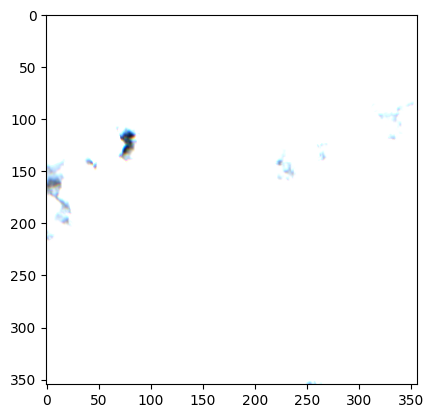

In [249]:
plt.imshow(array_1)

In [ ]:
np.max(array)

In [ ]:
array

In [ ]:
# download file

uri = 'gs://peru_images/2022-04-25_2022-04-29/lon_-78.78220_lat_-2.89890_lon_-78.75650_lat_-2.92399.tif'
img = ee.Image.loadGeoTIFF(uri)

# transform tif to numpy array

array = geemap.ee_to_numpy(ee_object = img)

# adjust colours

def scale_values(values):
    # Get the minimum and maximum values
    max_value_allowed = 3000
    min_value = np.min(values)
    max_value = np.max(values)
    # Calculate the range of the values
    value_range = max_value_allowed - min_value
    # Scale the values to a range of 0 to 1
    scaled_values = np.array([255*((value - min_value) / value_range) for value in values]).astype(int)
    scaled_values = np.where(scaled_values >= 255, 255, scaled_values)
    
    return  scaled_values

array_1= scale_values(array)

# check size 

print(array_1.shape)

# cut to 256x256

array_1 = array_1[0:256,0:256,:]

# take a look

plt.imshow(array_1)


In [151]:
Map = folium.Map(location=[area[1], area[0]], zoom_start=4)

Map.setOptions('ROADMAP')

In [152]:
Map.addLayer(big_image, rgbVis, 'Sentinel2')

In [150]:
Map.addLayer(img, rgbVis, 'cloud_save')

NameError: name 'img' is not defined

In [153]:
# Map.centerObject(Peru, 6)
Map.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map